## Problama viajero

El **Problema del Viajero** es un clásico de la optimización combinatoria. Se plantea así:

Un vendedor debe visitar un conjunto de ciudades exactamente una vez y regresar a la ciudad de origen. El objetivo es encontrar la ruta más corta posible.

Matemáticamente, si hay $n$ ciudades, el número de posibles rutas crece factorialmente ($(n-1)!$), lo que vuelve imposible revisar todas las combinaciones cuando $n$ es grande. Por eso, el TSP es un **problema NP-difícil**, y se suelen usar heurísticas o metaheurísticas para obtener buenas soluciones en un tiempo razonable.


### 1. Formulación del TSP como problema matemático

Sea un conjunto de ciudades $V = \{1,2,\dots,n\}$ y una matriz de distancias:

$$
D = [d_{ij}] \quad \text{con } d_{ij} \geq 0, \; d_{ii}=0
$$

donde $d_{ij}$ es la distancia entre la ciudad $i$ y la ciudad $j$.

El objetivo es encontrar un ciclo $C$ que:

1. Visite cada ciudad exactamente una vez.
2. Regrese a la ciudad de origen.
3. Tenga la menor longitud posible.

La función a **minimizar** es:

$$
f(\pi) = \sum_{k=1}^{n} d_{\pi(k), \pi(k+1)}
$$

donde $\pi$ es una permutación de las ciudades (un orden de visita), y se define $\pi(n+1) = \pi(1)$ para cerrar el ciclo.

👉 Entonces, el problema se resume en:

$$
\min_{\pi \in S_n} f(\pi)
$$

donde $S_n$ es el conjunto de todas las permutaciones posibles de $n$ ciudades.

### 2. Visión como un problema de grafos

El TSP puede modelarse como un **grafo completo y ponderado**:

$$
G = (V, E)
$$

* $V$: conjunto de nodos (ciudades).
* $E$: conjunto de aristas, cada una con un peso $d_{ij}$ (la distancia).

Un recorrido válido es un **ciclo Hamiltoniano**: un ciclo que pasa por cada vértice una única vez y regresa al inicio.

Por lo tanto:

* Resolver el TSP equivale a **encontrar el ciclo Hamiltoniano de peso mínimo** en el grafo.
* Esto lo hace un problema NP-difícil, ya que encontrar ciclos Hamiltonianos es en sí un problema difícil, y además debemos minimizar su longitud.

### 3. Conexión con Algoritmos Genéticos

Cuando usamos **algoritmos genéticos**, estamos buscando aproximar esta minimización:

* **Cromosoma (solución candidata)**: una permutación de ciudades (un posible ciclo Hamiltoniano).
* **Función de aptitud**: la inversa de la distancia total (por ejemplo, $ \text{fitness} = \frac{1}{f(\pi)}$) para que recorridos más cortos sean más "aptos".
* **Operadores evolutivos**: cruzar e intercambiar rutas para explorar el espacio de soluciones, sin tener que examinar las $(n-1)!$ posibilidades.

---

🔑 En resumen:

* El TSP es un **problema de optimización combinatoria** que busca el ciclo Hamiltoniano más corto en un grafo completo ponderado.
* Su función objetivo es la **minimización de la distancia total recorrida**.
* Los algoritmos genéticos ofrecen una manera heurística de atacar el problema, generando soluciones aproximadas de alta calidad en tiempos razonables.

In [1]:
# Importamos las librerias necesrias
import random
import numpy as np
from deap import base, creator, algorithms, tools
import json
import matplotlib.pyplot as plt

# importamos el  json que contiene la matriz de distancias entre ciudades
with open('./gr17.json', 'r') as tps_data:
    tps = json.load(tps_data)

# matriz de distancias
distance_map = tps['DistanceMatrix']

# numero de ciudades a visitar
ind_size = tps["TourSize"]

In [2]:
# 1. Definimos el problema de optimización
#    Usamos 'FitnessMin' porque queremos minimizar la distancia total del recorrido.
#    El parámetro weights=(-1.0,) indica que es un problema de minimización (distancia mínima).
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# 2. Definimos el tipo de individuo
#    Un individuo en este caso es una lista (una permutación de ciudades)
#    con un atributo 'fitness' asociado a 'FitnessMin'.
creator.create('Individual', list, fitness=creator.FitnessMin)

# 3. Instanciamos el objeto toolbox
toolbox = base.Toolbox()

# 3.1 Definimos el método "indices"
#     Este método genera un tour aleatorio (una permutación de todas las ciudades).
#     - random.sample(range(ind_size), ind_size) devuelve una lista con los números 0..(ind_size-1) en orden aleatorio.
#     - ind_size representa el número total de ciudades del TSP.
toolbox.register("indices", random.sample, range(ind_size), ind_size)

# 3.2 Generamos un método para crear individuos
#     - tools.initIterate: construye un individuo a partir de una función generadora.
#     - Aquí, esa función es toolbox.indices, que nos da un tour aleatorio.
#     - Es decir, cada vez que llamamos a 'individual()', obtenemos una permutación nueva de ciudades.
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indices)

# 3.3 Generamos un método para la población inicial
#     - tools.initRepeat: crea múltiples elementos aplicando repetidamente una función.
#     - Aquí se usa para construir una población de individuos.
toolbox.register('population', tools.initRepeat, list, toolbox.individual, 100)

# 4. Definimos la función objetivo
def evalTPS(individual):
    """
    Calcula la distancia total de un tour (ciclo) en el TSP.

    Parámetros:
    -----------
    individual : list[int]
        Lista de ciudades en el orden en que son visitadas.

    Retorna:
    --------
    tuple
        Distancia total recorrida (se devuelve como tupla por compatibilidad con DEAP).
    """

    # Distancia entre la última y la primera ciudad (para cerrar el ciclo)
    distance = distance_map[individual[-1]][individual[0]]

    # Suma de las distancias entre ciudades consecutivas en el tour
    for gen1, gen2 in zip(individual[:-1], individual[1:]):
        distance += distance_map[gen1][gen2]

    return distance,
   
# 5. Definimos las operaciones genéticas

# 5.1. Función de cruzamiento (crossover)
#      Usamos 'cxOrdered' porque está diseñado para problemas de permutación como el TSP.
#      Garantiza que el hijo resultante siga siendo una permutación válida
#      (sin ciudades repetidas ni perdidas).
toolbox.register('mate', tools.cxOrdered)

# 5.2. Función de mutación
#      Usamos 'mutShuffleIndexes', que intercambia aleatoriamente posiciones
#      dentro del tour con cierta probabilidad (indpb=0.05). 
#      Una forma de ajustarlo es hacerlo inv. proporcional al len('progenitores')
#      Valores de indpb muy grandes pueden probocar problemas de convergencia
#      Esto introduce diversidad en la población y ayuda a evitar estancarse
#      en óptimos locales.
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.05)

# 5.3. Función de selección
toolbox.register('select', tools.selTournament, tournsize=3)

# 5.4. Función de evaluación
toolbox.register('evaluate', evalTPS)



### Algoritmo genético mupluslambda

El **$(\mu + \lambda)$** es una **estrategia evolutiva elitista**, dentro de la familia de los **algoritmos genéticos y evolutivos**, donde:

* Se parte de una población de tamaño $\mu$ (padres).
* A partir de ellos se generan $\lambda$ descendientes mediante operadores genéticos.
* La siguiente generación se forma eligiendo los **$\mu$ mejores individuos entre padres y descendientes**.

Esto garantiza **preservación de la élite** (no se pierden las mejores soluciones encontradas).

#### Formalización Matemática

* Población de padres en la generación $t$:

  $$
  P^{(t)} = \{ x^{(t)}_1, x^{(t)}_2, \dots, x^{(t)}_\mu \}
  $$

* Se generan $\lambda$ descendientes aplicando operadores de **recombinación** y **mutación**:

  $$
  Q^{(t)} = \{ y^{(t)}_1, y^{(t)}_2, \dots, y^{(t)}_\lambda \}
  $$

* Nueva población:

  $$
  P^{(t+1)} = \text{select}_\mu \left( P^{(t)} \cup Q^{(t)} \right)
  $$

donde $\text{select}_\mu$ escoge los $\mu$ individuos con mejor fitness.

#### Propiedades Clave

* **Elitismo garantizado**: los mejores individuos nunca se pierden (a diferencia del $(\mu, \lambda)$).
* **Presión selectiva controlable**: depende de la relación $\lambda/\mu$.

  * $\lambda \gg \mu$: más exploración, alta diversidad.
  * $\lambda \approx \mu$: más explotación, refinamiento de soluciones.
* **Estabilidad**: converge de forma más controlada que el $(\mu, \lambda)$, aunque puede caer más fácilmente en óptimos locales.
* **Complejidad temporal**: $O((\mu + \lambda) \cdot C_{eval})$, donde $C_{eval}$ es el costo de evaluar el fitness.

#### Procedimiento Algorítmico

1. **Inicialización**
   Generar aleatoriamente $\mu$ individuos (padres).

2. **Evaluación**
   Calcular la función de fitness $f(x)$ para cada individuo.

3. **Reproducción**

   * Selección de progenitores ($x \in P^{(t)}$).
   * Aplicar **crossover** con probabilidad $p_c$.
   * Aplicar **mutación** con probabilidad $p_m$.
     → Generar $Q^{(t)}$ de tamaño $\lambda$.

4. **Evaluación de descendientes**
   Calcular $f(y)$ para cada $y \in Q^{(t)}$.

5. **Selección de nueva población**

   $$
   P^{(t+1)} \gets \text{los } \mu \text{ mejores individuos en } P^{(t)} \cup Q^{(t)}
   $$

6. **Criterio de parada**
   Se repite hasta alcanzar número máximo de generaciones, convergencia del fitness, o límite de cómputo.

---

#### Implementación en DEAP

En DEAP, se usa con la función:

```python
algorithms.eaMuPlusLambda(pop, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                          stats=None, halloffame=None, verbose=__debug__)
```

* `mu`: número de padres.
* `lambda_`: número de descendientes por generación.
* `cxpb`: probabilidad de crossover.
* `mutpb`: probabilidad de mutación.
* `ngen`: número de generaciones.
* `halloffame`: (opcional) almacena los mejores individuos globales.

---

#### Comparación con $(\mu, \lambda)$

| Estrategia        | Selección de nueva población | Elitismo | Riesgo                                                         |
| ----------------- | ---------------------------- | -------- | -------------------------------------------------------------- |
| $(\mu, \lambda)$  | solo entre descendientes     | ❌        | mayor exploración, pero riesgo de pérdida de buenas soluciones |
| $(\mu + \lambda)$ | entre padres + descendientes | ✅        | más estable, pero riesgo de estancamiento en óptimos locales   |

---

👉 En conclusión:
El **$(\mu + \lambda)$** es un **algoritmo evolutivo elitista** que asegura progreso estable al mantener a los mejores individuos de generación en generación. Es útil cuando se busca **robustez** y se puede tolerar menor diversidad en favor de **convergencia más rápida y estable**.

In [20]:
def main(cross, mut):
    """
    Ejecuta un algoritmo genético (eaMuPlusLambda) para resolver el TSP con DEAP.

    Parámetros:
    -----------
    cross : float
        Probabilidad de crossover (cruce).
    mut : float
        Probabilidad de mutación.

    Retorna:
    --------
    hof : tools.HallOfFame
        Contiene los mejores individuos encontrados.
    logbook : tools.Logbook
        Registro con estadísticas de cada generación.
    """

    # Probabilidades de crossover y mutación, y número de generaciones
    CXPB, MUTPB, NGEN = cross, mut, 120

    # Generamos población inicial
    pop = toolbox.population()

    # Hall of Fame: mantiene los mejores individuos encontrados (aquí, el mejor)
    hof = tools.HallOfFame(1)

    # Definimos los parámetros de (μ + λ):
    # - MU: número de padres
    # - LAMBDA: número de descendientes
    MU, LAMBDA = len(pop), len(pop)

    # Objeto para registrar estadísticas de cada generación
    # tools.Statistics recibe una función que extrae los valores de fitness
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Registramos las métricas de interés:
    stats.register('avg', np.mean)  # fitness promedio
    stats.register('std', np.std)   # desviación estándar
    stats.register('min', np.min)   # mejor fitness (mínimo)
    stats.register('max', np.max)   # peor fitness (máximo)

    # Objeto para guardar el log de ejecución
    logbook = tools.Logbook()

    # Ejecutamos el algoritmo evolutivo (estrategia μ + λ)
    # - pop: población inicial
    # - MU, LAMBDA: número de padres y descendientes
    # - CXPB, MUTPB: probabilidades de crossover y mutación
    # - NGEN: número de generaciones
    # - stats: estadísticas por generación
    # - halloffame: almacena los mejores individuos globales
    # - verbose=False: evita imprimir cada generación en pantalla
    pop, logbook = algorithms.eaMuPlusLambda(
        pop, toolbox, MU, LAMBDA, 
        CXPB, MUTPB, NGEN, 
        stats=stats, halloffame=hof, verbose=False
    )

    return hof, logbook


if __name__ == "__main__":

    # Fijamos semilla para reproducibilidad
    random.seed(100)

    # Definimos listas de probabilidades de crossover y mutación a explorar
    pop_cruce = [x for x in np.arange(0.8,0.2,-0.1)]
    pop_mutacion = [x for x in np.arange(0.1,0.4,0.05)]

    # Archivos de salida para registrar los resultados
    # ⚠️ El modo 'v' no es válido, debería usarse 'w' para escritura.
    fichero_fitness = open("fitnessTSP.out", 'w')
    fichero_individuo = open("individuoTSP.out", 'w')

    # Bucle de experimentación:
    # - combinamos probabilidades de crossover y mutación
    # - repetimos 10 veces cada experimento para robustez
    for c, m in zip(pop_cruce, pop_mutacion):
        for i in range(20):

            # Ejecutamos el algoritmo con parámetros actuales
            best, log = main(c, m)

            # Guardamos en fichero de fitness:
            # experimento, crossover, mutación, fitness del mejor individuo
            fichero_fitness.write(str(i)+', '+str(c)+', '+str(m)+', ')
            fichero_fitness.write(str(best[0].fitness.values[0]))
            fichero_fitness.write('\n')

            # Guardamos en fichero de individuos:
            # experimento, crossover, mutación, mejor solución (ruta encontrada)
            fichero_individuo.write(str(i)+', '+str(c)+', '+str(m)+', ')
            fichero_individuo.write(str(best[0]))
            fichero_individuo.write('\n')

    # Cerramos los archivos de salida
    fichero_fitness.close()
    fichero_individuo.close()


### Visulaización de resultados para su posterior análisis


=== Resumen por (cx, mut) ===
 index  cx  mut  count    mean        std    min    max
     4 0.6 0.20     20 2119.75  31.495823 2085.0 2184.0
     3 0.5 0.25     20 2135.40  37.442447 2085.0 2216.0
     5 0.7 0.15     20 2137.80  56.771564 2085.0 2274.0
     1 0.3 0.35     20 2139.85  37.940778 2095.0 2248.0
     6 0.8 0.10     20 2140.30  55.315459 2085.0 2249.0
     2 0.4 0.30     20 2142.20  43.850944 2085.0 2245.0
     0 0.2 0.40     20 2165.30 124.879352 2090.0 2664.0

=== Top-5 configuraciones por fitness medio (↓ mejor) ===
 index  cx  mut  count    mean       std    min    max
     4 0.6 0.20     20 2119.75 31.495823 2085.0 2184.0
     3 0.5 0.25     20 2135.40 37.442447 2085.0 2216.0
     5 0.7 0.15     20 2137.80 56.771564 2085.0 2274.0
     1 0.3 0.35     20 2139.85 37.940778 2095.0 2248.0
     6 0.8 0.10     20 2140.30 55.315459 2085.0 2249.0

=== Mejor ejecución global ===
fitness=2085.0000 | cx=0.8 | mut=0.1 | run=10
individuo (ruta): [13, 16, 5, 7, 6, 12, 3, 0, 15, 11, 

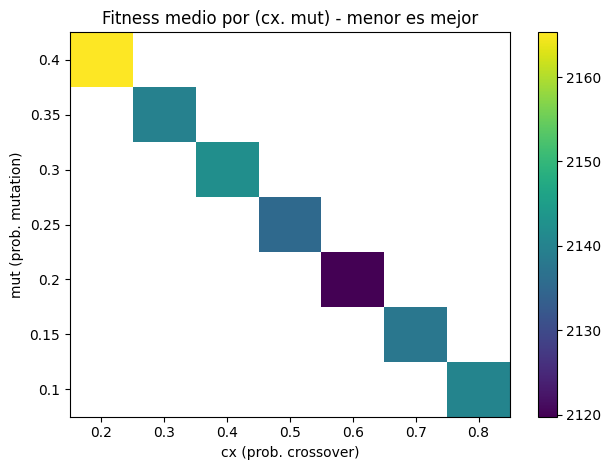

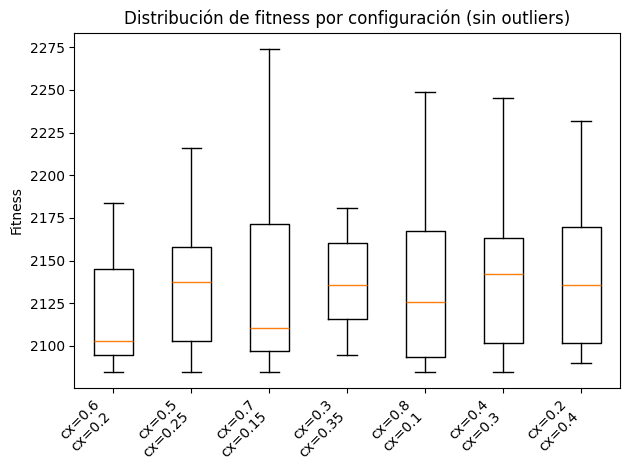

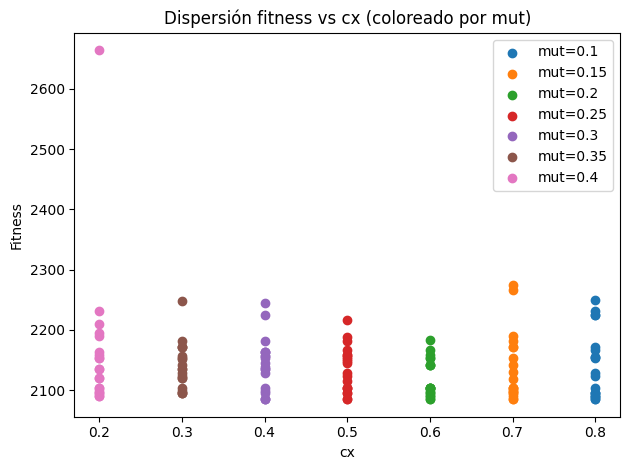

In [28]:
import ast              # Convierte cadenas de texto en estructuras Python (listas, diccionarios, etc.)
import csv              # Lectura y escritura de archivos en formato CSV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path # Manejo de rutas y archivos de forma más sencilla y portable


# --------------- Carga de datos --------------
def load_fitness(path='fitnessTSP.out'):
    """
        Carga el archivo con resultados de fitness.
    
        Parámetros
        ----------
        path : str
            Ruta al archivo fitnessTSP.out
    
        Retorna
        -------
        DataFrame con columnas:
            run : int → número de repetición del experimento
            cx : float → probabilidad de crossover
            mut : float → probabilidad de mutación
            fitness : float → fitness del mejor individuo
    """
    rows=[]
    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for raw in reader:
            if not raw:
                continue
            # Unimos y separamos manualmente para manejar espacios extra
            parts = [p.strip() for p in ','.join(raw).split(',')]
            if len(parts) != 4:
                continue
            run, cx, mut, fit = parts
            rows.append({
                "run": int(run),
                "cx": float(cx),
                "mut": float(mut),
                "fitness": float(fit)
            })
        return pd.DataFrame(rows)

def load_individuals(path='individuoTSP.out'):
    """
        Carga el archivo con los mejores individuos de cada ejecución.
    
        Parámetros
        ----------
        path : str
            Ruta al archivo individuoTSP.out
    
        Retorna
        -------
        DataFrame con columnas:
            run : int → número de repetición del experimento
            cx : float → probabilidad de crossover
            mut : float → probabilidad de mutación
            individuo : list[int] → mejor ruta encontrada
    """
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for raw in reader:
            if not raw:
                continue
            parts = [p.strip() for p in ','.join(raw).split(',')]
            # Deben existir al menos run, cx, mut + individuo
            if len(parts) < 4:
                continue
            run = int(parts[0]); cx = float(parts[1]); mut = float(parts[2])

            # El individuo puede tener comas internas, se reconstruye
            indiv_str = ','.join(parts[3:]).strip()

            try:
                individuo = ast.literal_eval(indiv_str) # convierte string en lista
            except Exception:
                individuo = indiv_str
            
            rows.append({"run": run, "cx": cx, "mut": mut, "individuo": individuo})
   
    return pd.DataFrame(rows)

# ------------------ Procesamiento de datos ----------------------

# Cargamos fitness e individuos
df_fit = load_fitness('fitnessTSP.out')
df_ind = load_individuals('individuoTSP.out')

# Asociamos fitness <-> individuo por (run, cx, mut)
df = pd.merge(df_fit, df_ind, on=['run', 'cx', 'mut'], how='left')

# Calculamos métricas resumen por configuración
summary = (df.groupby(['cx','mut'], as_index=False)['fitness']
                .agg(count='count', mean='mean', std='std', min='min', max='max')
                .reset_index()
                .sort_values(["mean", "std"], ascending=[True, True])
                )

# Imprimimos resumen de configuraciones
print("\n=== Resumen por (cx, mut) ===")
print(summary.to_string(index=False))

# Top-5 configuraciones por fitness medio (menor es mejor)
print("\n=== Top-5 configuraciones por fitness medio (↓ mejor) ===")
print(summary.nsmallest(5, "mean").to_string(index=False))

# Mejor ejecución global
best_row = df.nsmallest(1, "fitness").iloc[0]
print("\n=== Mejor ejecución global ===")
print(f"fitness={best_row.fitness:.4f} | cx={best_row.cx} | mut={best_row.mut} | run={best_row.run}")
print(f"individuo (ruta): {best_row.individuo}\n")

# ---------------- 3) Visualizaciones ------------------

# 3.1 Heatmap: fitness medio por configuración (cx, mut)
# Creamos una tabla pivote: filas = mut, columnas = cx, valores = media del fitness
pivot = summary.pivot(index='mut', columns='cx', values='mean').sort_index(ascending=True)

plt.figure()  # Nueva figura
# Dibujamos la matriz de valores de fitness medio como imagen de colores
plt.imshow(pivot.values, aspect='auto', origin='lower')
# Etiquetas en el eje X = valores de cx
plt.xticks(ticks=range(pivot.shape[1]), labels=[f"{c:g}" for c in pivot.columns])
# Etiquetas en el eje Y = valores de mut
plt.yticks(ticks=range(pivot.shape[0]), labels=[f"{r:g}" for r in pivot.index])
plt.xlabel("cx (prob. crossover)")
plt.ylabel("mut (prob. mutación)")
plt.title("Fitness medio por (cx, mut) - menor es mejor")
# Barra de colores a la derecha para interpretar valores
cbar = plt.colorbar()
plt.tight_layout()
plt.show()


# 3.2 Boxplots: distribución del fitness por configuración
# Creamos una etiqueta de configuración (cx, mut) para cada fila
df['cfg'] = df['cx'].map(lambda x: f"cx={x:g}") + "\n" + df["mut"].map(lambda x: f"mut={x:g}")
# Ordenamos las configuraciones según fitness medio (de mejor a peor)
order = (df.groupby("cfg")["fitness"].mean().sort_values().index.tolist())

plt.figure()  # Nueva figura
# Preparamos los datos de fitness agrupados por configuración
data = [df.loc[df["cfg"]==k, "fitness"].values for k in order]
# Dibujamos los boxplots (sin outliers para no distorsionar la escala)
plt.boxplot(data, tick_labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")  # Rotamos etiquetas para mejor lectura
plt.ylabel("Fitness")
plt.title("Distribución de fitness por configuración (sin outliers)")
plt.tight_layout()
plt.show()


# 3.3 Dispersión: fitness vs cx coloreado por mutación
plt.figure()  # Nueva figura

# Recorremos cada grupo de mutación y dibujamos sus puntos
for mut_val, sub in df.groupby('mut'):
    # Dibujamos un scatter: eje X = cx, eje Y = fitness
    # Cada mutación aparece con color distinto y etiqueta en la leyenda
    plt.scatter(sub["cx"], sub["fitness"], label=f"mut={mut_val:g}")

plt.xlabel("cx")
plt.ylabel("Fitness")
plt.title("Dispersión fitness vs cx (coloreado por mut)")
plt.legend()   # Mostramos la leyenda con mutaciones
plt.tight_layout()
plt.show()
